Mounting google drive (If using google colab and have uploaded dataset to drive. For Our use, we have done this)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


check if mount successful

In [ ]:
!ls "/content/drive/My Drive/Dataset/train"

'Healthy Tomato'  'Tomato Early blight leaf'  'Wheat leaf septoria'
'Healthy Wheat'   'Tomato leaf late blight'   'Wheat leaf stripe rust'


In [ ]:
!ls "/content/drive/My Drive/Dataset/test"

'Healthy Tomato'  'Tomato Early blight leaf'  'Wheat leaf septoria'
'Healthy Wheat'   'Tomato leaf late blight'   'Wheat leaf stripe rust'


Import all necessary libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from os import listdir
import tensorflow as tf
from keras.utils import img_to_array, to_categorical
from keras.layers import Dense, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from keras.applications import vgg16
from keras.models import Model
from sklearn.metrics import classification_report
import seaborn as sns

Check tf version, if not working, change to 2.12.0

In [ ]:
print(tf.__version__)

2.15.0


Visualise random images and also analyse the dimensions

Convert to numpy array


In [ ]:
def convert_image_to_array(image_dir):
  try:
    image = cv2.imread(image_dir)
    if image is not None:
      image = cv2.resize(image, (224,224))
      return img_to_array(image)
    else:
      return np.array([])
  except Exception as e:
    print(f"Error : {e}")
    return None

Add train and test directories before running

In [ ]:
dir_train = "/content/drive/My Drive/Dataset/train"
dir_test = "/content/drive/My Drive/Dataset/test"

image_list_train, label_list_train = [], []
image_list_test, label_list_test = [], []

all_labels = [
              'Tomato Early blight leaf', 'Tomato leaf', 'Tomato leaf late blight',
    'Wheat leaf Healthy', 'Wheat leaf septoria', 'Wheat leaf stripe_rust'
    ]

binary_labels = [0, 1, 2
                 , 3, 4, 5
                 ]

temp = -1

for directory in all_labels:
    plant_image_list = listdir(f"{dir_train}/{directory}")
    temp += 1
    for files in plant_image_list:
      image_path = f"{dir_train}/{directory}/{files}"
      image_list_train.append(convert_image_to_array(image_path))
      label_list_train.append(binary_labels[temp])

temp = -1

for directory in all_labels:
    plant_image_list = listdir(f"{dir_test}/{directory}")
    temp += 1
    for files in plant_image_list:
      image_path = f"{dir_test}/{directory}/{files}"
      image_list_test.append(convert_image_to_array(image_path))
      label_list_test.append(binary_labels[temp])

split train set into validation and create test set as well

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(image_list_train, label_list_train, test_size = 0.2, random_state = 42)
x_test = image_list_test
y_test = label_list_test

normalize


In [ ]:
x_train = np.array(x_train, dtype = np.float16) / 255.0
x_val = np.array(x_val, dtype = np.float16) / 255.0
x_test = np.array(x_test, dtype = np.float16) / 255.0
x_train = x_train.reshape(-1, 224, 224, 3)
x_val = x_val.reshape(-1, 224, 224, 3)
x_test = x_test.reshape(-1, 224, 224, 3)

one-hot encode target variable

In [ ]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

download vgg and initalise

In [ ]:
img_rows, img_cols = 224, 224

vgg = vgg16.VGG16(weights = 'imagenet',
                 include_top = False, # making sure not to take last layer
                 input_shape = (img_rows, img_cols, 3))

# dont keep layers of pretrained model as trainable =
for layer in vgg.layers:
    layer.trainable = False

vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

create extra layers

In [ ]:
def lw(bottom_model, num_classes):
    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(256,activation='relu')(top_model)
    top_model = Dense(128,activation='relu')(top_model)
    top_model = Dense(96,activation='relu')(top_model)
    top_model = Dense(64,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model

join model

In [ ]:
num_classes = 6
FC_Head = lw(vgg, num_classes)
model = Model(inputs = vgg.input, outputs = FC_Head)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

compile and train

In [ ]:
model.compile(optimizer='adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])
history = model.fit(x_train,y_train,
                    epochs=25,
                    validation_data=(x_val,y_val),
                    verbose = 1,
                    initial_epoch=0)

Epoch 1/25
16/16 [==============================] - 23s 633ms/step - loss: 1.6256 - accuracy: 0.3406 - val_loss: 1.3481 - val_accuracy: 0.4844
Epoch 2/25
16/16 [==============================] - 3s 167ms/step - loss: 1.1557 - accuracy: 0.5571 - val_loss: 0.8972 - val_accuracy: 0.6641
Epoch 3/25
16/16 [==============================] - 3s 167ms/step - loss: 0.7320 - accuracy: 0.7106 - val_loss: 0.6339 - val_accuracy: 0.7891
Epoch 4/25
16/16 [==============================] - 3s 170ms/step - loss: 0.5177 - accuracy: 0.8130 - val_loss: 0.4840 - val_accuracy: 0.8047
Epoch 5/25
16/16 [==============================] - 3s 161ms/step - loss: 0.4732 - accuracy: 0.8110 - val_loss: 0.4379 - val_accuracy: 0.8438
Epoch 6/25
16/16 [==============================] - 3s 169ms/step - loss: 0.3802 - accuracy: 0.8484 - val_loss: 0.5260 - val_accuracy: 0.7734
Epoch 7/25
16/16 [==============================] - 3s 161ms/step - loss: 0.3242 - accuracy: 0.8681 - val_loss: 0.4133 - val_accuracy: 0.8516
Epoch

extract accuracy and loss

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plot accuracy for training and validation

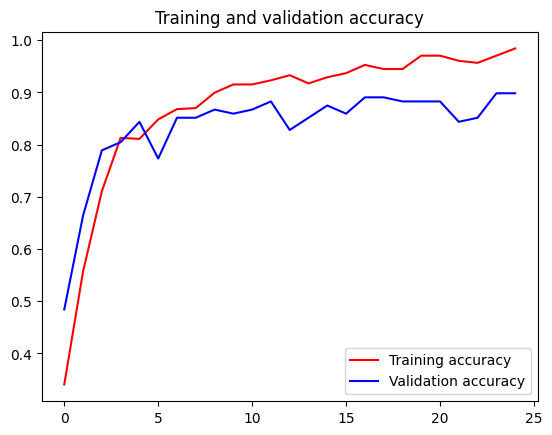

<Figure size 640x480 with 0 Axes>

In [ ]:
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

plot loss for training and validation

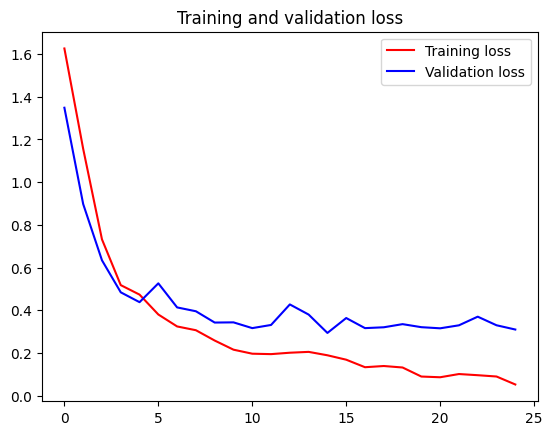

<Figure size 640x480 with 0 Axes>

In [ ]:
epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()

print test accuracy

In [ ]:
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

2/2 [==============================] - 5s 5s/step - loss: 0.5300 - accuracy: 0.8704
Test Accuracy: 87.03703880310059


get predictions

In [ ]:
y_pred = model.predict(x_test)

2/2 [==============================] - 0s 108ms/step


print true labels - predictions

In [ ]:
for i in range(len(y_pred)):
  print(all_labels[np.argmax(y_test[i])], "-", all_labels[np.argmax(y_pred[i])])

Tomato Early blight leaf - Tomato Early blight leaf
Tomato Early blight leaf - Tomato Early blight leaf
Tomato Early blight leaf - Tomato Early blight leaf
Tomato Early blight leaf - Tomato Early blight leaf
Tomato Early blight leaf - Tomato leaf late blight
Tomato Early blight leaf - Tomato Early blight leaf
Tomato Early blight leaf - Tomato Early blight leaf
Tomato Early blight leaf - Tomato leaf late blight
Tomato Early blight leaf - Tomato Early blight leaf
Tomato Early blight leaf - Tomato Early blight leaf
Tomato leaf - Tomato leaf
Tomato leaf - Tomato leaf
Tomato leaf - Tomato leaf
Tomato leaf - Tomato Early blight leaf
Tomato leaf - Tomato leaf
Tomato leaf - Tomato leaf
Tomato leaf - Tomato leaf
Tomato leaf - Tomato leaf
Tomato leaf late blight - Tomato leaf late blight
Tomato leaf late blight - Tomato leaf late blight
Tomato leaf late blight - Tomato leaf late blight
Tomato leaf late blight - Tomato leaf late blight
Tomato leaf late blight - Tomato Early blight leaf
Tomato lea

In [ ]:
# model.save_weights("/content/drive/My Drive/wheat_tomato_disease_prediction_model_weights.h5")

In [ ]:
# model.load_weights("/content/drive/My Drive/wheat_tomato_disease_prediction_model_weights.h5")

16/16 [==============================] - 2s 122ms/step


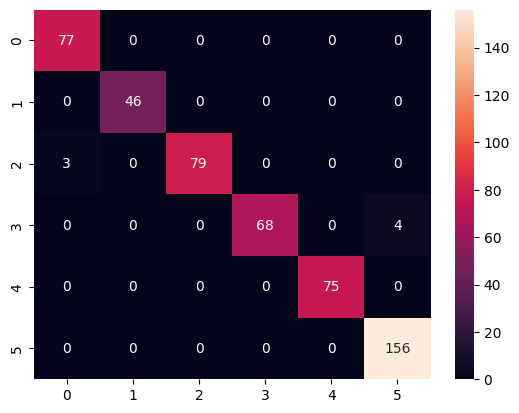

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        77
           1       1.00      1.00      1.00        46
           2       1.00      0.96      0.98        82
           3       1.00      0.94      0.97        72
           4       1.00      1.00      1.00        75
           5       0.97      1.00      0.99       156

    accuracy                           0.99       508
   macro avg       0.99      0.98      0.99       508
weighted avg       0.99      0.99      0.99       508



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get the predicted labels for the validation set
y_pred = model.predict(x_train)
y_pred = np.argmax(y_pred, axis=1)

# Get the true labels for the validation set
y_true = np.argmax(y_train, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

print(classification_report(y_true, y_pred))

4/4 [==============================] - 0s 116ms/step


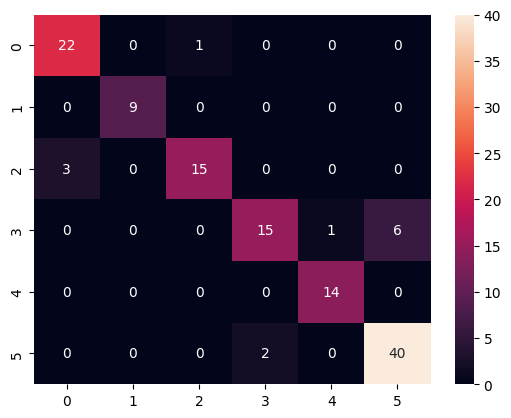

              precision    recall  f1-score   support

           0       0.88      0.96      0.92        23
           1       1.00      1.00      1.00         9
           2       0.94      0.83      0.88        18
           3       0.88      0.68      0.77        22
           4       0.93      1.00      0.97        14
           5       0.87      0.95      0.91        42

    accuracy                           0.90       128
   macro avg       0.92      0.90      0.91       128
weighted avg       0.90      0.90      0.90       128



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get the predicted labels for the validation set
y_pred = model.predict(x_val)
y_pred = np.argmax(y_pred, axis=1)

# Get the true labels for the validation set
y_true = np.argmax(y_val, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

print(classification_report(y_true, y_pred))

2/2 [==============================] - 0s 108ms/step


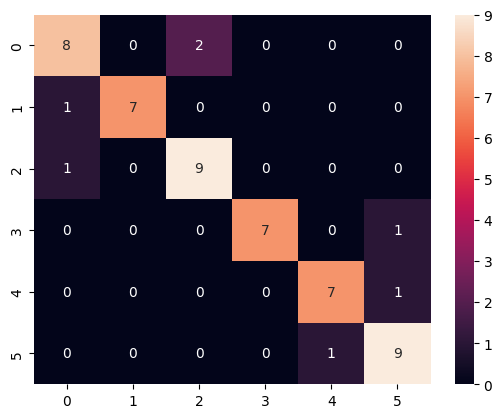

              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       1.00      0.88      0.93         8
           2       0.82      0.90      0.86        10
           3       1.00      0.88      0.93         8
           4       0.88      0.88      0.88         8
           5       0.82      0.90      0.86        10

    accuracy                           0.87        54
   macro avg       0.89      0.87      0.88        54
weighted avg       0.88      0.87      0.87        54



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get the predicted labels for the validation set
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

# Get the true labels for the validation set
y_true = np.argmax(y_test, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

print(classification_report(y_true, y_pred))